<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indicators/blob/main/Code/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 376s 97ms/step - loss: 0.1975 - val_loss: 0.1375
Epoch 2/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 361s 91ms/step - loss: 0.1493 - val_loss: 0.1291
Epoch 3/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 388s 93ms/step - loss: 0.1386 - val_loss: 0.1243
Epoch 4/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 379s 92ms/step - loss: 0.1330 - val_loss: 0.1209
Epoch 5/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 368s 97ms/step - loss: 0.1295 - val_loss: 0.1176
Epoch 6/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 348s 92ms/step - loss: 0.1262 - val_loss: 0.1167
Epoch 7/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 367s 97ms/step - loss: 0.1240 - val_loss: 0.1184
Epoch 8/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 364s 92ms/step - loss: 0.1236 - val_loss: 0.1154
Epoch 9/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 380s 91ms/step - loss: 0.1208 - val_loss: 0.1161
Epoch 10/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 383s 92ms/step - loss: 0.1183 - val_loss: 0.1140
Epoch 11/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 346s 91ms/step - loss: 0.1192 - val_loss: 0.11

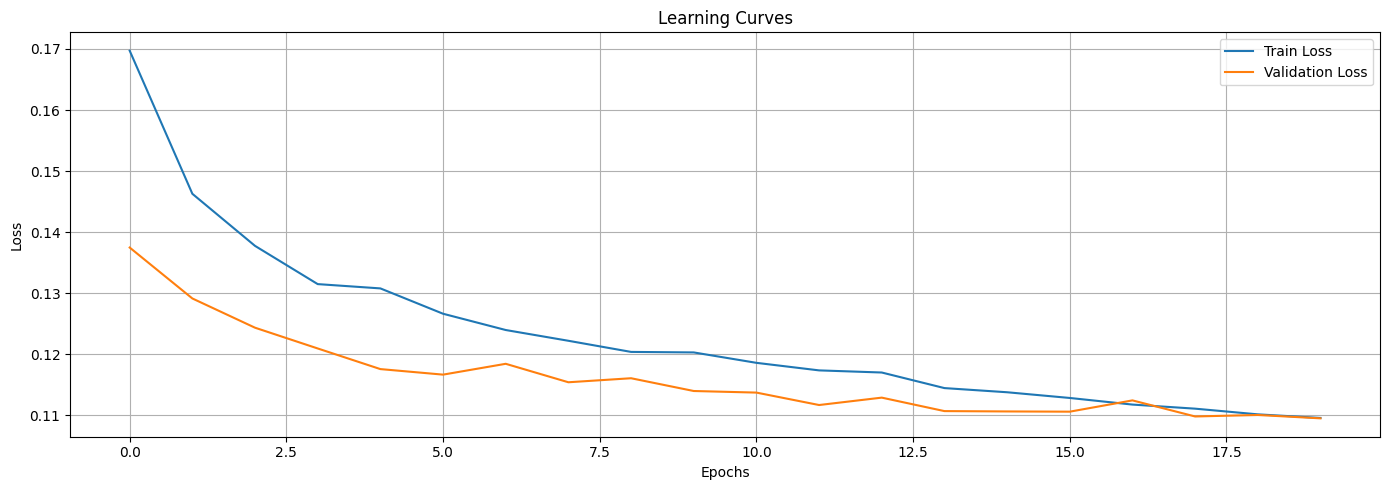

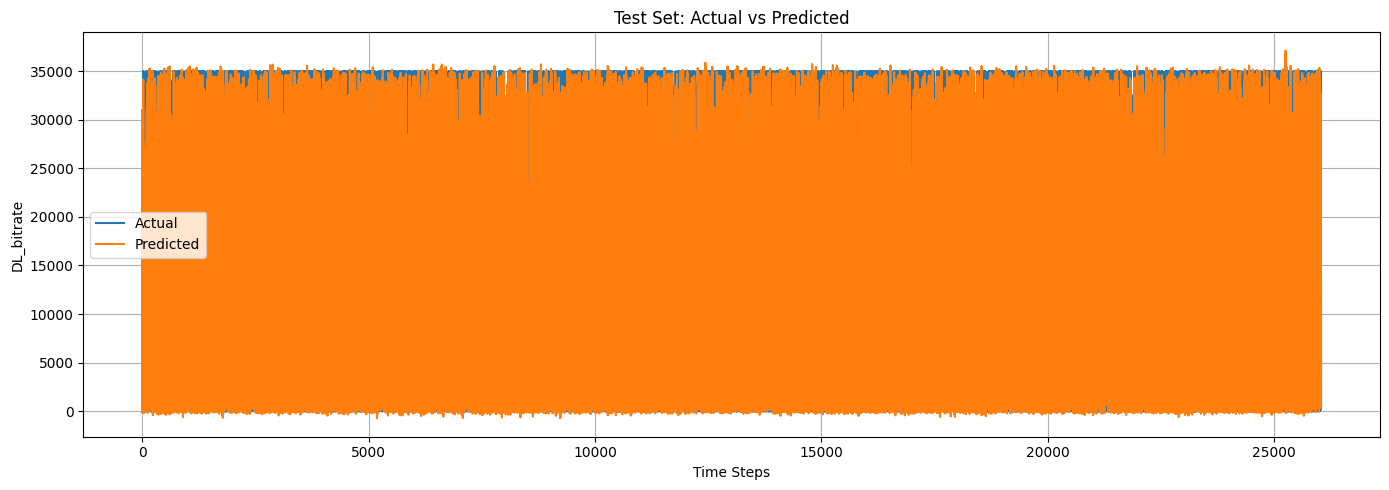

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt

# Δημιουργία time-series windows
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Φόρτωση dataset
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")
target = "DL_bitrate"
features = df.drop(columns=[target])
target = df[target]

# Κανονικοποίηση
feature_scaler = StandardScaler()
features_scaled = pd.DataFrame(feature_scaler.fit_transform(features), columns=features.columns, index=features.index)

target_scaler = StandardScaler()
target_scaled = pd.Series(target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten(), index=target.index)

# Δημιουργία χρονικών παραθύρων
TIME_STEPS = 96
X, y = create_dataset(features_scaled, target_scaled, TIME_STEPS)

# Διαχωρισμός σε train/val/test (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Μοντέλο LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Εκπαίδευση
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Προβλέψεις για όλα τα σύνολα
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Αντιστροφή κανονικοποίησης
y_train_orig = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_orig = target_scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1))

y_train_pred_orig = target_scaler.inverse_transform(y_train_pred)
y_val_pred_orig = target_scaler.inverse_transform(y_val_pred)
y_test_pred_orig = target_scaler.inverse_transform(y_test_pred)

# Υπολογισμός μετρικών
def print_metrics(name, true, pred):
    mse = mean_squared_error(true, pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"\n{name} Set Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

print_metrics("Train", y_train_orig, y_train_pred_orig)
print_metrics("Validation", y_val_orig, y_val_pred_orig)
print_metrics("Test", y_test_orig, y_test_pred_orig)


# Οπτικοποίηση Learning Curves
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Learning Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Οπτικοποίηση Actual vs Predicted για Test
plt.figure(figsize=(14, 5))
plt.plot(y_test_orig, label='Actual')
plt.plot(y_test_pred_orig, label='Predicted')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("DL_bitrate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()








**We calculate for better understanding the percentages of the error metrics to see how far the predictions are from the average actual DL_bitrate of the test data.**

In [17]:
# Υπολογισμός της μέσης πραγματικής τιμής του test set
mean_actual_value = y_test_orig.mean()
print(f"Μέση πραγματική τιμή στο Test Set: {mean_actual_value:.4f}")

# Υπολογισμός σφαλμάτων
rmse = sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))
mae = mean_absolute_error(y_test_orig, y_test_pred_orig)

# Σφάλματα ως ποσοστό της μέσης τιμής
rmse_pct = (rmse / mean_actual_value) * 100
mae_pct = (mae / mean_actual_value) * 100

print(f"\nΣφάλματα ως ποσοστό της μέσης τιμής:")
print(f"RMSE (%): {rmse_pct:.2f}%")
print(f"MAE  (%): {mae_pct:.2f}%")


Μέση πραγματική τιμή στο Test Set: 9872.3669

Σφάλματα ως ποσοστό της μέσης τιμής:
RMSE (%): 36.88%
MAE  (%): 22.14%
